In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss
import pandas as pd
from torch import optim
import re
import json
import cv2
import types

from utils import *

In [2]:
j = json.load(open('data/annotations.json'))

In [3]:
j[0]

{'annotations': [{'class': 'fluke',
   'height': 372.0,
   'type': 'rect',
   'width': 1017.0,
   'x': 14.0,
   'y': 97.0},
  {'class': 'left',
   'type': 'point',
   'x': 50.802273527488566,
   'y': 98.58659021176},
  {'class': 'notch',
   'type': 'point',
   'x': 516.2391276137811,
   'y': 269.48861474128864},
  {'class': 'right',
   'type': 'point',
   'x': 1013.5305065138045,
   'y': 102.10753986218477}],
 'class': 'image',
 'filename': '6138dce83.jpg'}

In [4]:
len(j)

400

In [4]:
# idxs = np.arange(len(j))
# np.random.seed(0)
# np.random.shuffle(idxs)
# val_idxs = idxs[:100]

In [5]:
# val_j = [anno for i, anno in enumerate(j) if i in val_idxs]
# trn_j = [anno for i, anno in enumerate(j) if i not in val_idxs]

In [6]:
# len(trn_j), len(val_j)

(300, 100)

In [10]:
# pd.to_pickle([anno['filename'] for anno in val_j], 'data/val_fns_detection.pkl') # this will allow me to use the same validation set across NBs

The above annotations are in coco dataset format (x, y, width, height). The fastai library expects bbox coordinates to be in the format of (y_upper_left, x_upper_left, y_lower_right, x_lower_right) with the origin being in the upper left hand corner of the image.

In [3]:
SZ = 224
BS = 64
NUM_WORKERS = 12

In [4]:
def anno2bbox(anno):
    im_width, im_height = PIL.Image.open(f"data/train/{anno['filename']}").size
    anno = list(filter(lambda a: a['class'] == 'fluke', anno['annotations']))[0]
    return [
        np.clip(anno['y'], 0, im_height) / im_height * SZ, #scale bbox to 224 (or SZ)
        np.clip(anno['x'], 0, im_width) / im_width * SZ,
        np.clip(anno['y']+anno['height'], 0, im_height) / im_height * SZ,
        np.clip(anno['x']+anno['width'], 0, im_width) / im_width * SZ
    ]

Just some small functions that will be helpful as we construct our dataset.

In [5]:
fn2bbox = {jj['filename']: [[anno2bbox(jj)], ['fluke']] for jj in j}
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)
get_y_func = lambda o: fn2bbox[path2fn(o)]

In [6]:
fn2bbox['6138dce83.jpg']

[[[36.21333333333333,
   2.986666666666667,
   175.09333333333333,
   219.9466666666667]],
 ['fluke']]

In [7]:
val_fns = pd.read_pickle('data/val_fns_detection.pkl') # I create this file in fluke_detection.ipynb

ObjectCategoryList is designed to be used in a full object recognition scenario (multiple bounding boxes per image, objects of multiple classes). Since that is more functionality than we require (and more than our model will predict - our objects will always be of the same class, 'fluke', and we will be predicting just a single bounding box per image) I make minor changes to ObjectCategoryList.

In [8]:
class StubbedObjectCategoryList(ObjectCategoryList):
    def analyze_pred(self, pred): return [pred.unsqueeze(0), torch.ones(1).long()]

In [26]:
fn2bbox.keys()

dict_keys(['6138dce83.jpg', '0dcfd05bf.jpg', '57583a290.jpg', 'e29fc82ff.jpg', '53bb428e9.jpg', '6ddd0e118.jpg', '9b7b61f03.jpg', '031e52425.jpg', '324066278.jpg', 'b8c4be531.jpg', 'a82cbc84b.jpg', '004775679.jpg', 'd407d7ee0.jpg', '63492795c.jpg', 'fe576c02a.jpg', '90662e7b1.jpg', '241c16bd3.jpg', '7edbdca82.jpg', '89056eba7.jpg', 'a44546471.jpg', '1bad21820.jpg', '60deefe6e.jpg', '00bc4dade.jpg', '428e8c768.jpg', '57b9ec865.jpg', '9d2027918.jpg', '7f1d4c51d.jpg', 'c30634691.jpg', 'bc9a158e6.jpg', 'a35bb0c62.jpg', 'f96f5ef25.jpg', 'f6218e09a.jpg', '7c5b419b6.jpg', 'd8137387b.jpg', '12035e558.jpg', '122f497db.jpg', 'd47fb8ef3.jpg', 'c0127fb8b.jpg', '0415a291e.jpg', '67816b034.jpg', '4214483ad.jpg', '38b21b86b.jpg', 'a1ee12c36.jpg', '4cb092141.jpg', '75f13f76e.jpg', 'c999130ea.jpg', 'c7114f25c.jpg', '821c2335e.jpg', 'ba289a66b.jpg', '0483452b5.jpg', '870523991.jpg', 'e13819377.jpg', '8a4d94342.jpg', '016ac2f79.jpg', 'b41bed9da.jpg', '04eb3829e.jpg', 'a6473910b.jpg', '7417d47d7.jpg', '3f

In [9]:
data = (ObjectItemList.from_df(pd.DataFrame(data=list(fn2bbox.keys())), path='data/train-224')
        .split_by_valid_func(lambda path: path2fn(path) in val_fns)                         
        .label_from_func(get_y_func, label_cls=StubbedObjectCategoryList)
        .transform(get_transforms(max_zoom=1, max_warp=0.05, max_rotate=0.05, max_lighting=0.2), tfm_y=True, size=(SZ,SZ), resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS)
        .normalize(imagenet_stats))

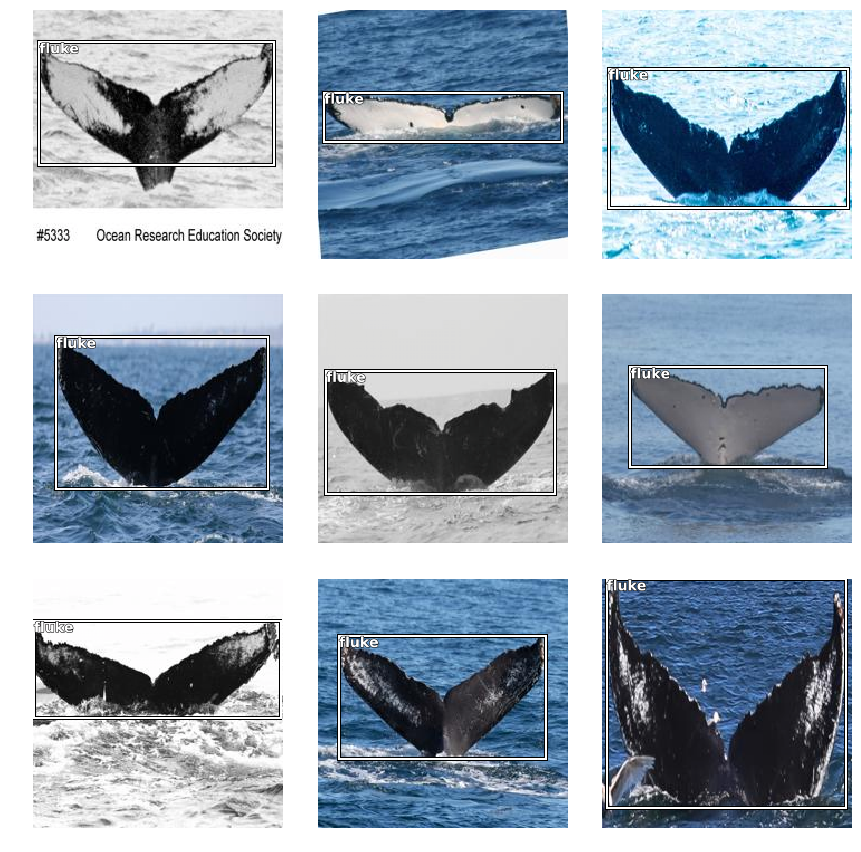

In [10]:
data.show_batch(rows=3, ds_type=DatasetType.Valid, figsize=(12,12))

In [11]:
class FlukeDetector(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        self.cnn = create_body(arch) # last conv2d->batchnorm: 512,7,7
        self.head = create_head(num_features_model(self.cnn) * 2, 4) 
        # add adapconcat and 2 nn.linear: 1024 to 512, 512 to 4 (coords) with bn,dropout ...
        
    def forward(self, im):
        x = self.cnn(im)
        x = self.head(x)
        return 2 * (x.sigmoid_() - 0.5) #scaling between -1 and 1

In [12]:
def loss_fn(preds, targs, class_idxs):
    return L1Loss()(preds, targs.squeeze())

In [13]:
learn = Learner(data, FlukeDetector(arch=models.resnet50), loss_func=loss_fn)
learn.metrics = [lambda preds, targs, _: IoU(preds, targs.squeeze()).mean()]

In [14]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])

In [15]:
learn.freeze_to(-1)

In [16]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,
1,0.782925,0.734241,0.000001
2,0.767204,0.770995,0.000017
3,0.728246,0.854859,0.008647
4,0.639481,0.206244,0.566872
5,0.529433,0.206361,0.604391
6,0.452737,0.181936,0.624320
7,0.396082,0.140349,0.674396
8,0.351767,0.111994,0.711947
9,0.316842,0.101372,0.733864
10,0.288472,0.099673,0.738787


In [16]:
# learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,
1,0.772527,0.798867,0.000000
2,0.763410,0.800455,0.000548
3,0.725678,0.800279,0.017194
4,0.639308,0.220938,0.564017
5,0.530437,0.157470,0.667477
6,0.450821,0.168413,0.646527
7,0.392218,0.156084,0.653809
8,0.348442,0.140046,0.665435
9,0.314346,0.121695,0.706105
10,0.286541,0.114142,0.724231


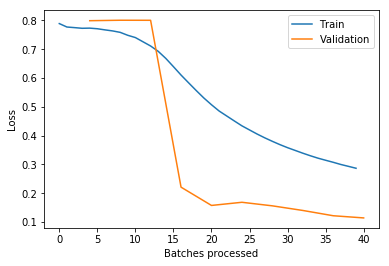

In [17]:
learn.recorder.plot_losses()

In [20]:
learn.unfreeze()

In [21]:
max_lr = 2e-3
lrs = [max_lr/100, max_lr/10, max_lr]

In [22]:
learn.fit_one_cycle(40, lrs, div_factor=20)

epoch,train_loss,valid_loss,
1,0.111954,0.098162,0.744475
2,0.114584,0.097068,0.747165
3,0.110865,0.096433,0.753161
4,0.108282,0.092593,0.759580
5,0.106431,0.092754,0.756128
6,0.105032,0.090310,0.762349
7,0.103492,0.080315,0.782523
8,0.102222,0.085655,0.765241
9,0.100642,0.082187,0.783654
10,0.098298,0.078097,0.788698


In [20]:
# learn.fit_one_cycle(40, lrs, div_factor=20)

epoch,train_loss,valid_loss,
1,0.117067,0.107134,0.740147
2,0.115032,0.104660,0.745270
3,0.114068,0.105499,0.742223
4,0.111720,0.100619,0.749310
5,0.110276,0.095699,0.756791
6,0.108149,0.090163,0.769526
7,0.106420,0.095683,0.756616
8,0.105466,0.089593,0.757499
9,0.103375,0.088832,0.762985
10,0.101511,0.090514,0.766422


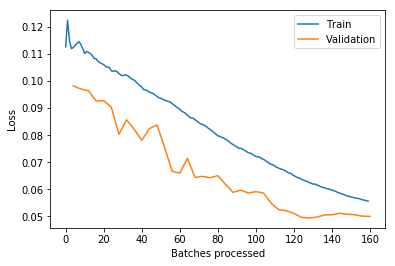

In [23]:
learn.recorder.plot_losses()

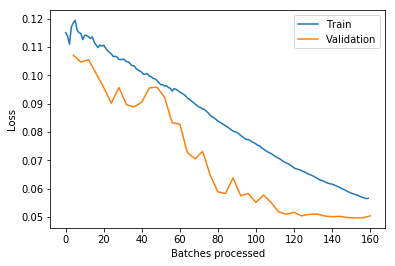

In [21]:
# learn.recorder.plot_losses()

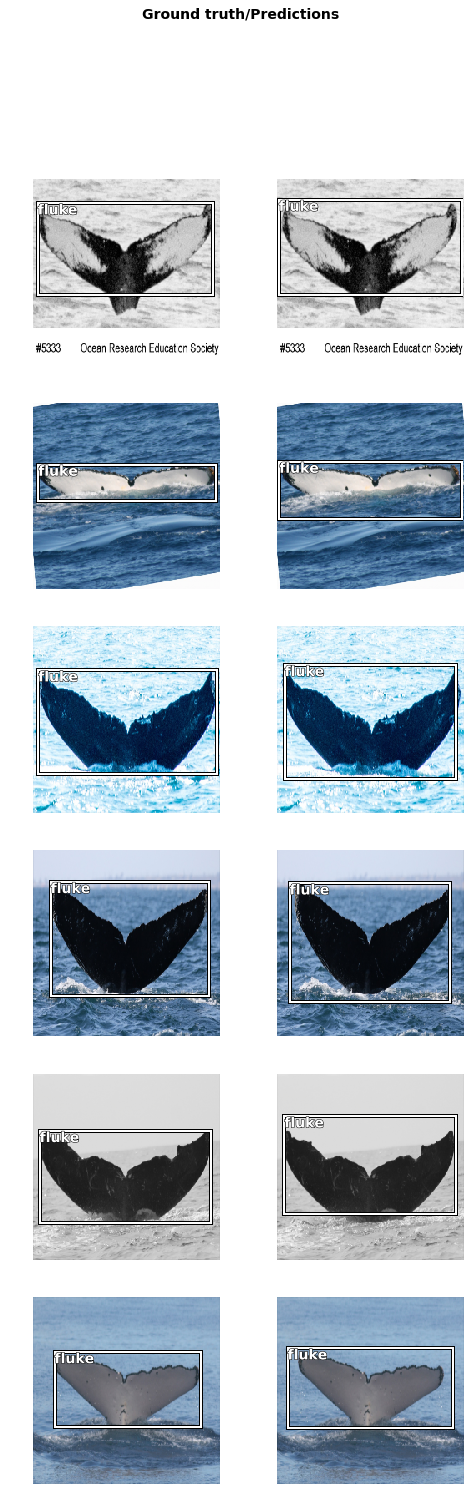

In [23]:
learn.show_results(rows=6)

In [24]:
preds, targs = learn.get_preds()

predicted_bboxes = ((preds + 1) / 2 * SZ).numpy() #scale to [0,1] then to [0,224]
targets = ((targs + 1) / 2 * SZ).numpy().squeeze()

def draw_bbox(img, bbox, target=None, color=(255, 0, 0), thickness=2):
    y_min, x_min, y_max, x_max = map(int, bbox)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    if target is not None:
        y_min, x_min, y_max, x_max = map(int, target)
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(0,255,0), thickness=thickness)
    return img

def cv_read(path):    
    im = cv2.imread(path, cv2.IMREAD_COLOR)
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [33]:
preds[0]

tensor([-0.8025, -0.9725,  0.2383,  0.9724])

In [34]:
targs[0]

tensor([[-0.7440, -0.9571,  0.2400,  0.9257]])

In [35]:
predicted_bboxes[0]

array([ 22.117535,   3.082534, 138.68454 , 220.91342 ], dtype=float32)

In [25]:
i=0
temp = draw_bbox(cv_read(data.valid_ds.items[i]), predicted_bboxes[i], targets[i])

In [26]:
temp.shape

(224, 224, 3)

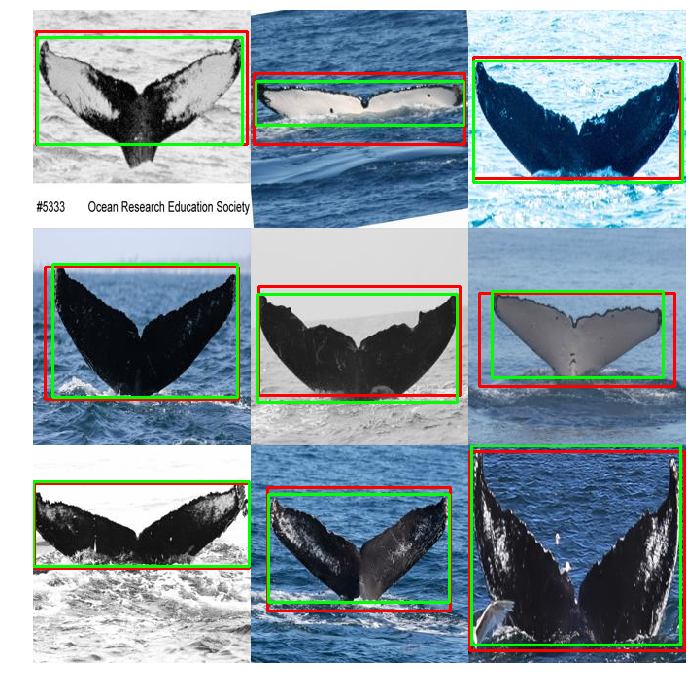

In [27]:
# Targets are in green, predictions in red.
ims = np.stack([draw_bbox(cv_read(data.valid_ds.items[i]), predicted_bboxes[i], targets[i]) for i in range(9)])
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))